In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from lifelines import KaplanMeierFitter

# generate random data
np.random.seed(42)
n = 100
start_date = datetime(2022, 1, 1)
df = pd.DataFrame({
    'buyer_id': np.random.choice(range(1, 21), n),
    'order_date': [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n)],
    'group': np.random.choice(['A', 'B'], n),
    'positive_experience': np.random.choice([True, False], n)
})

In [2]:
df.head()

,buyer_id,order_date,group,positive_experience,time_to_next_order,cohort,cohort_week
8,11,2022-09-14,A,False,126.0,2022-04-23,20
18,12,2022-06-28,A,False,137.0,2022-02-11,19
22,15,2022-08-29,A,False,-119.0,2022-02-21,12
25,12,2022-08-10,B,False,-61.0,2022-02-11,14
26,20,2022-08-19,B,False,59.0,2022-03-07,23


<AxesSubplot:xlabel='timeline'>

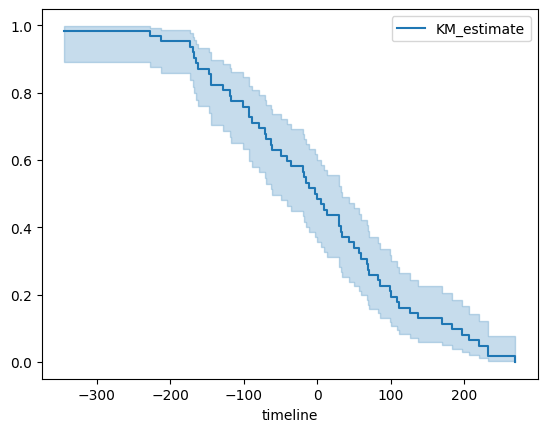

In [1]:
# add time to next order column
df['time_to_next_order'] = df.groupby(['buyer_id', 'group'])['order_date'].diff()

# convert to time delta object
df['time_to_next_order'] = df['time_to_next_order'].dt.days

# create cohort and week columns
df['cohort'] = df.groupby('buyer_id')['order_date'].transform('min')
df['cohort_week'] = df.groupby(['group', 'cohort'])['order_date'].apply(lambda x: (x - x.min()).dt.days // 7)
df = df.dropna()

# create Kaplan-Meier survival curve
kmf = KaplanMeierFitter()
T = df['time_to_next_order']
E = np.ones(len(df))
kmf.fit(T, event_observed=E)

# plot the survival curve
kmf.plot()

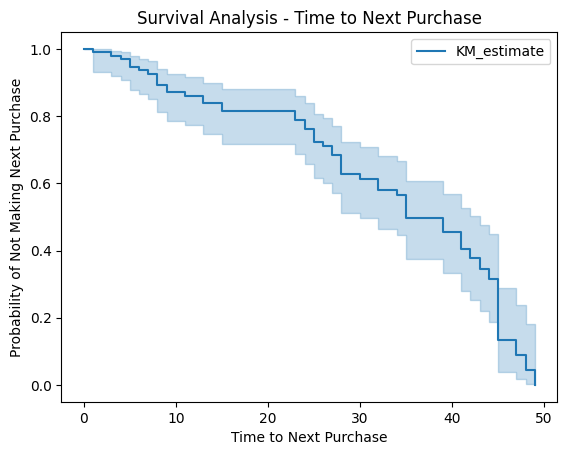

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# generate random data
np.random.seed(42)

df = pd.DataFrame({
    'buyer_id': np.random.randint(1000, 1100, size=100),
    'order_create_date': pd.date_range(start='2022-01-01', periods=100, freq='D'),
    'next_order_create_date': pd.date_range(start='2022-01-05', periods=100, freq='D'),
    'time_to_next_order': np.random.randint(1, 50, size=100),
    'buyer_feedback': np.random.choice([0, 1], size=100, p=[0.4, 0.6])
})

df['order_create_weekly_period'] = df['order_create_date'].dt.strftime('%Y-%U')
df['next_order_create_weekly_period'] = df['next_order_create_date'].dt.strftime('%Y-%U')
df['cohort_week'] = df.groupby('buyer_id')['order_create_weekly_period'].transform('min')

# create cohort table
cohort_df = df.groupby(['cohort_week', 'order_create_weekly_period'])['buyer_id'].nunique().reset_index()
cohort_df['period_number'] = (cohort_df['order_create_weekly_period'].apply(lambda x: int(x.split('-')[1]))
                              - cohort_df['cohort_week'].apply(lambda x: int(x.split('-')[1])) + 1)
cohort_pivot = cohort_df.pivot_table(index='cohort_week', columns='period_number', values='buyer_id')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# plot cohort table
plt.figure(figsize=(10, 5))
plt.title('Cohort Analysis - Retention Rates')
plt.xticks(rotation=90)
plt.xlabel('Cohort Week')
plt.ylabel('Weeks Since Initial Purchase')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().get_yaxis().set_visible(False)

for i in range(retention_matrix.shape[0]):
    for j in range(retention_matrix.shape[1]):
        plt.text(j+0.5, i+0.5, '{:.1%}'.format(retention_matrix.values[i, j]), ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='lightgrey'))

plt.show()

# conduct survival analysis
T = df['time_to_next_order']
E = df['buyer_feedback']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.title('Survival Analysis - Time to Next Purchase')
plt.xlabel('Time to Next Purchase')
plt.ylabel('Probability of Not Making Next Purchase')
plt.show()



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate random data
np.random.seed(1)
data = pd.DataFrame({
    'buyer_id': np.random.randint(100, size=100),
    'order_create_date': pd.date_range(start='2021-01-01', periods=100),
    'next_order_create_date': pd.date_range(start='2021-01-02', periods=100),
    'time_to_next_order': np.random.randint(1, 10, size=100),
})

# Create cohort table
data['order_create_weekly_period'] = data['order_create_date'].dt.strftime('%Y-%U')
data['next_order_create_weekly_period'] = data['next_order_create_date'].dt.strftime('%Y-%U')
grouping = data.groupby(['order_create_weekly_period', 'next_order_create_weekly_period'])
cohort_data = grouping.agg(n_buyers=('buyer_id', 'nunique')).reset_index(drop=False)
cohort_counts = cohort_data.pivot_table(index='order_create_weekly_period',
                                         columns='next_order_create_weekly_period',
                                         values='n_buyers')

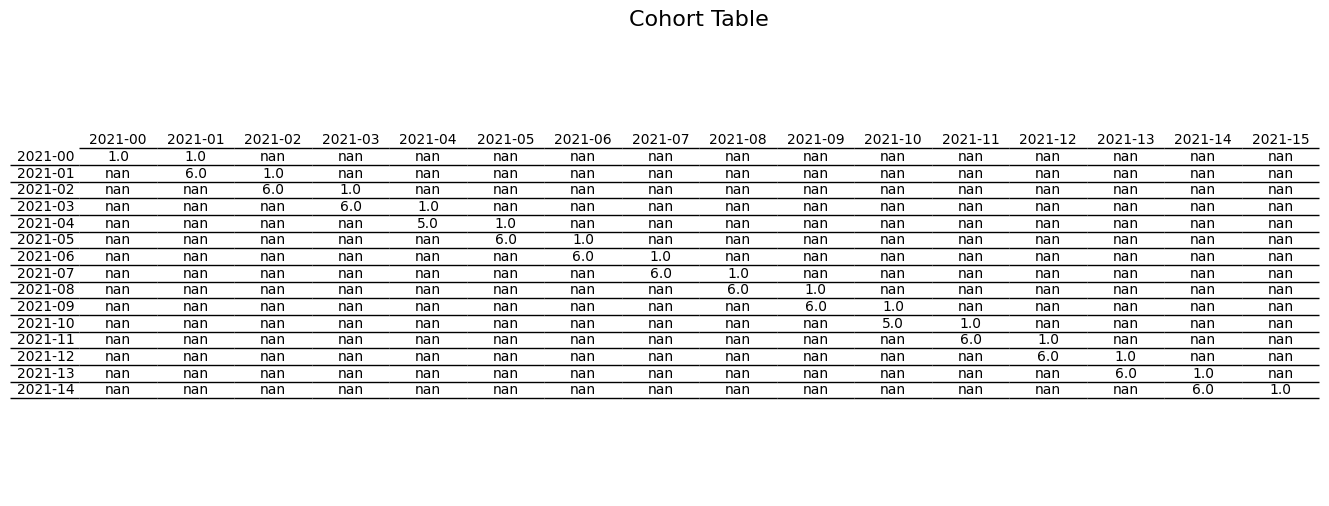

In [6]:
# Create cohort table with borders
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=cohort_counts.values,
          colLabels=cohort_counts.columns,
          rowLabels=cohort_counts.index,
          loc='center',
          cellLoc='center',
          colWidths=[0.1]*len(cohort_counts.columns),
          edges='B',
          fontsize=14)
ax.set_title('Cohort Table', fontsize=16)
plt.show()

In [7]:
# Create survival analysis plot
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T = data['time_to_next_order']
E = np.ones(len(data))
for period in data['order_create_weekly_period'].unique():
    period_mask = data['order_create_weekly_period'] == period
    kmf.fit(T[period_mask], event_observed=E[period_mask], label=period)
    kmf.plot(ax=ax, ci_show=False)
    
ax.set_xlabel('Time to Next Order (days)', fontsize=14)
ax.set_ylabel('Survival Probability', fontsize=14)
ax.set_title('Survival Analysis by Cohort', fontsize=16)
ax.legend(fontsize=12)

plt.show()

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate random data
np.random.seed(1)
data = pd.DataFrame({
    'venture': np.random.choice(['A', 'B', 'C'], size=100),
    'buyer_id': np.random.randint(1000, 1100, size=100),
    'buyer_feedback_id': np.random.randint(100, 110, size=100),
    'order_create_date': pd.date_range(start='2022-01-01', periods=100),
    'order_create_weekly_period': pd.date_range(start='2022-01-01', periods=100, freq='W-MON'),
    'next_order_create_date': pd.date_range(start='2022-01-01', periods=100) + pd.Timedelta(days=30),
    'next_order_create_weekly_period': pd.date_range(start='2022-01-01', periods=100, freq='W-MON') + pd.Timedelta(days=30),
    'cohort_week': pd.Series((pd.to_datetime(data['order_create_date']) - pd.to_datetime(data['order_create_weekly_period'])).dt.days / 7).astype(int),
    'next_buyer_feedback_id': np.random.randint(100, 110, size=100),
})
data['time_to_next_order'] = (data['next_order_create_date'] - data['order_create_date']).dt.days
data = data[data['time_to_next_order'] > 0]

# Create cohort table
cohort = data.groupby(['order_create_weekly_period', 'cohort_week'])['buyer_id'].nunique()
cohort = cohort.reset_index()
cohort_table = pd.pivot_table(cohort, values='buyer_id', index='order_create_weekly_period', columns='cohort_week')
cohort_size = cohort_table.iloc[:, 0]
retention = cohort_table.divide(cohort_size, axis=0)

# Create cohort plot
plt.figure(figsize=(15, 10))
plt.title('Retention Rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.1, vmax=1, cmap='Blues', cbar_kws={'label': 'Retention Rate'})
plt.xlabel('Cohort Week')
plt.ylabel('Order Create Weekly Period')
plt.show()

# Create cohort table with color scaling
def color_scale(val):
    color = 'background-color: '
    if val >= 0.5:
        color += 'darkblue'
    elif val >= 0.3:
        color += 'blue'
    elif val >= 0.1:
        color += 'lightblue'
    else:
        color += 'white'
    return color

cohort_table_styled = cohort_table.style.applymap(color_scale)
cohort_table_styled.set_properties(**{'border-color': 'black', 'border-style': 'solid'})
cohort_table_styled.set_table_styles([{'selector': 'th', 'props': [('border', '1px solid black')]}])
cohort_table_styled


KeyError: 'order_create_date'